

# Multi Task Learning with NLP (Project)
> #### Detect Emotions, Violence, Hate from text



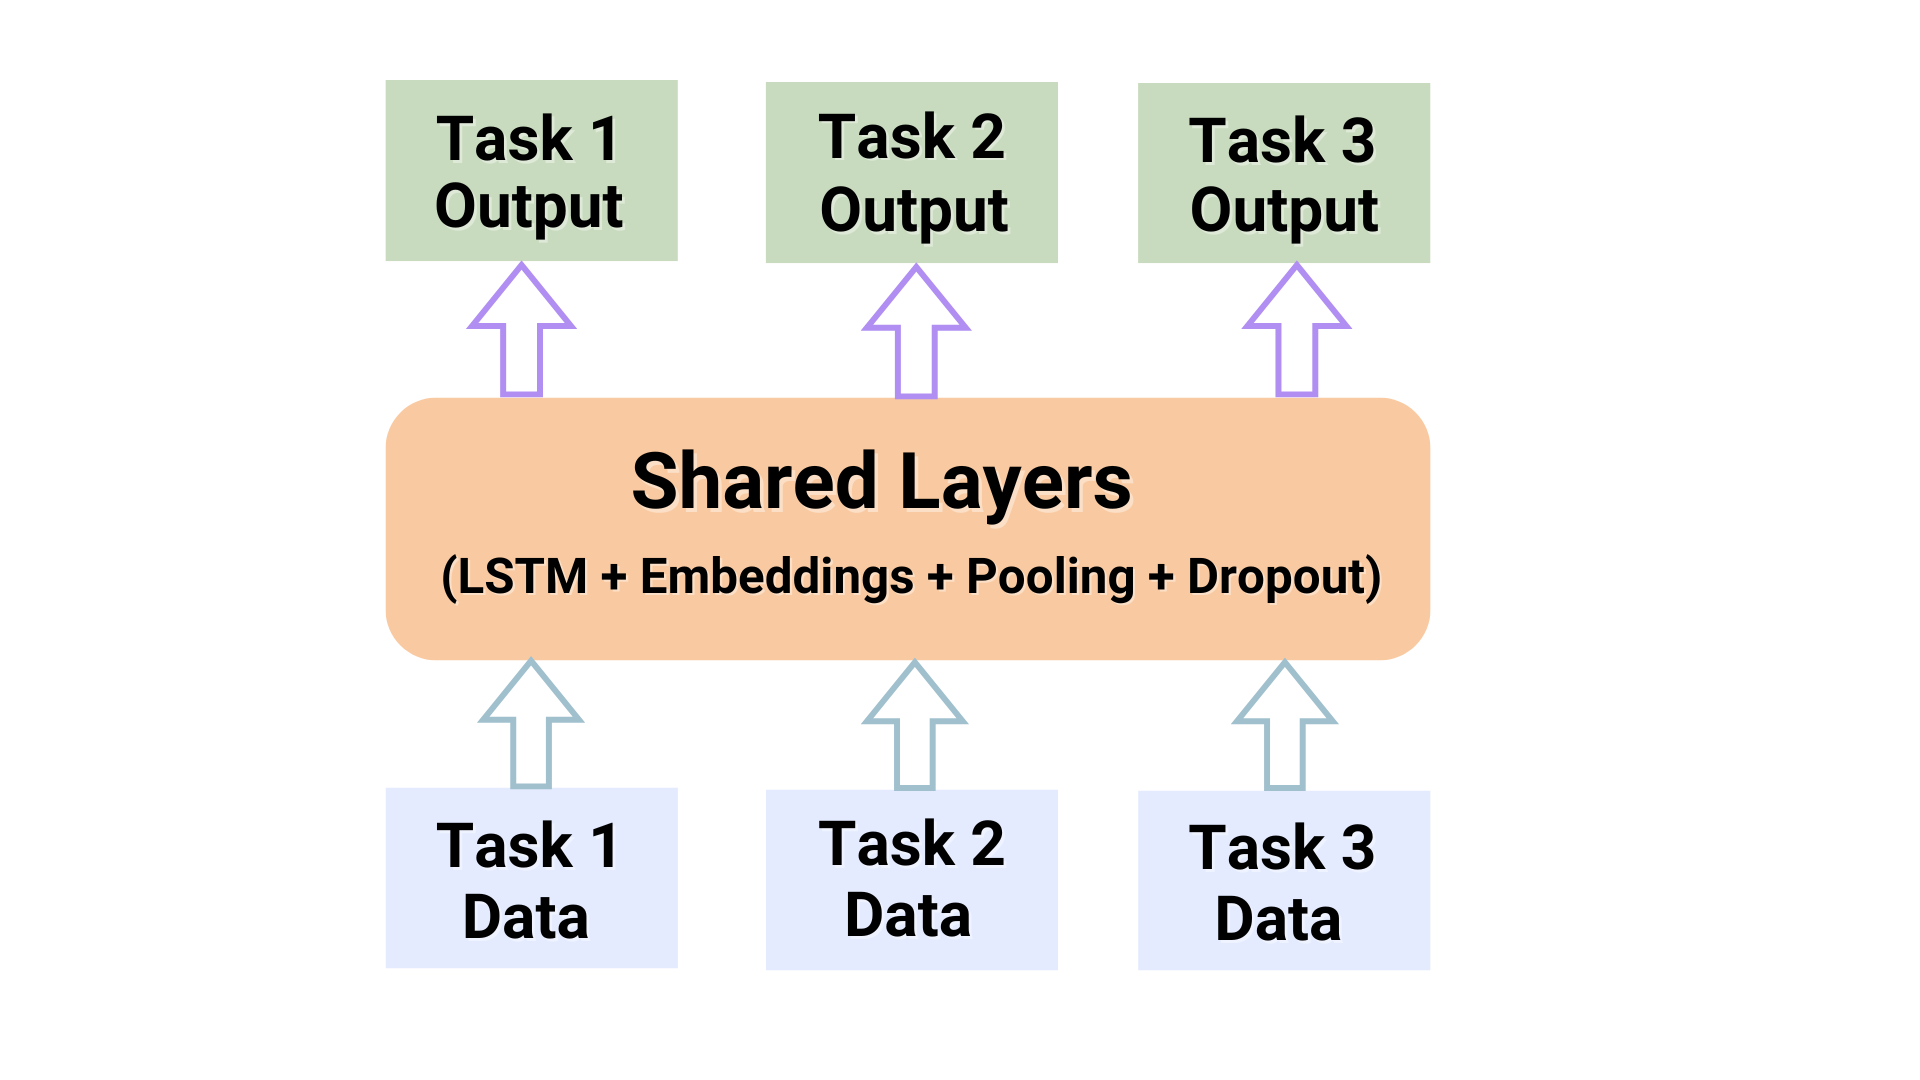

**Emotions**<br>
`0` : Sadness<br>
`1` : Joy<br>
`2` : Love<br>
`3` : Anger<br>
`4` : Fear<br>
`5` : Surprise

**Violence**<br>
`0` : Harmful_Traditional_practice<br>
`1` : Physical_violence<br>
`2` : economic_violence<br>
`3` : emotional_violence<br>
`4` : sexual_violence<br>

**Hate**<br>
`0` : Hate Speech<br>
`1` : Offensive Speech<br>
`2` : Neither

**1. Loading the Data**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
emotion_df = pd.read_csv('/content/emotions.csv')

In [ ]:
emotion_df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
violence_df = pd.read_csv('/content/violence.csv')

In [ ]:
violence_df.head()

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence


In [ ]:
hate_df = pd.read_csv('/content/hatespeech.csv')

In [ ]:
hate_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


**2. Data Preprocessing**

In [ ]:
#dropping unwanted columns
emotion_df.drop(columns = ['Unnamed: 0'], inplace = True)
violence_df.drop(columns = ['Tweet_ID'], inplace = True)
hate_df = hate_df[['tweet', 'class']]

In [ ]:
emotion_df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
violence_df.head()

,tweet,type
0,Had a dream i got raped last night. By a guy i...,sexual_violence
1,he thought the word raped means sex and told m...,sexual_violence
2,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,Chessy Prout can do better by telling the trut...,sexual_violence


In [ ]:
hate_df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [ ]:
emotion_df.columns, violence_df.columns, hate_df.columns

(Index(['text', 'label'], dtype='object'),
 Index(['tweet', 'type'], dtype='object'),
 Index(['tweet', 'class'], dtype='object'))

In [ ]:
#renaming the column
violence_df.rename(columns = {'tweet' : 'text', 'type' : 'label'}, inplace = True)
hate_df.rename(columns = {'tweet' : 'text', 'class' : 'label'}, inplace = True)

In [ ]:
emotion_df.columns, violence_df.columns, hate_df.columns

(Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'),
 Index(['text', 'label'], dtype='object'))

In [ ]:
#checking for null values
emotion_df.isna().sum(), violence_df.isna().sum(), hate_df.isna().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

In [ ]:
emotion_df.shape, violence_df.shape, hate_df.shape

((416809, 2), (39650, 2), (24783, 2))

Taking(Extracting) 12 thousand rows from each dataset

In [ ]:
emotion_df['label'].value_counts()

,count
label,
1,141067
0,121187
3,57317
4,47712
2,34554
5,14972


In [ ]:
e_df = pd.DataFrame()
for i in range(6):
  subset = emotion_df[emotion_df['label'] == i].sample(n = 2000, random_state = 42)
  e_df = pd.concat([e_df, subset])

In [ ]:
e_df.shape

(12000, 2)

In [ ]:
emotion_df = e_df.copy()

In [ ]:
emotion_df['label'].value_counts()

,count
label,
0,2000
1,2000
2,2000
3,2000
4,2000
5,2000




---



In [ ]:
violence_df['label'].value_counts()

,count
label,
sexual_violence,32648
Physical_violence,5946
emotional_violence,651
economic_violence,217
Harmful_Traditional_practice,188


In [ ]:
#we just want 4998 rows from the sexual_violence label
sexual_violence = violence_df[violence_df['label'] == 'sexual_violence'].sample(n = 4998, random_state = 42)
violence_df = violence_df[violence_df['label'] != 'sexual_violence']

In [ ]:
violence_df.shape

(7002, 2)

In [ ]:
violence_df = pd.concat([sexual_violence, violence_df], axis = 0)

In [ ]:
violence_df.shape

(12000, 2)



---



In [ ]:
hate_df['label'].value_counts()

,count
label,
1,19190
2,4163
0,1430


In [ ]:
offensive_speech = hate_df[hate_df['label'] == 1].sample(n = 6407, random_state = 42)
hate_df = hate_df[hate_df['label'] != 1]

In [ ]:
hate_df.shape

(5593, 2)

In [ ]:
hate_df = pd.concat([offensive_speech, hate_df], axis = 0)

In [ ]:
hate_df.shape

(12000, 2)

In [ ]:
emotion_df.shape, violence_df.shape, hate_df.shape

((12000, 2), (12000, 2), (12000, 2))

In [ ]:
emotion_df.head(3)

,text,label
133243,ive learned to surround myself with women who ...,0
88501,i already feel crappy because of this and you ...,0
131379,i feel like i have lost mourned and moved past...,0


In [ ]:
violence_df.head(3)

,text,label
35209,My cousin was raped by this guy Matthew. She w...,sexual_violence
38191,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,sexual_violence
20925,I remember how I almost got raped like it was ...,sexual_violence


In [ ]:
hate_df.head(3)

,text,label
22889,Why is it everytime I go to cracker barrel the...,1
20565,"Run that nigga, you don't want that nigga, but...",1
10780,I need a girl from Jamaica I can't fuck with t...,1


In [ ]:
#resetting the indexes
emotion_df.reset_index(drop = True, inplace = True)
violence_df.reset_index(drop = True, inplace = True)
hate_df.reset_index(drop = True, inplace = True)

In [ ]:
emotion_df.head(3)

,text,label
0,ive learned to surround myself with women who ...,0
1,i already feel crappy because of this and you ...,0
2,i feel like i have lost mourned and moved past...,0


In [ ]:
violence_df.head(3)

,text,label
0,My cousin was raped by this guy Matthew. She w...,sexual_violence
1,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,sexual_violence
2,I remember how I almost got raped like it was ...,sexual_violence


In [ ]:
hate_df.head(3)

,text,label
0,Why is it everytime I go to cracker barrel the...,1
1,"Run that nigga, you don't want that nigga, but...",1
2,I need a girl from Jamaica I can't fuck with t...,1


**3. Label Encoding**

In [ ]:
label_encoder = LabelEncoder()
violence_df['label'] = label_encoder.fit_transform(violence_df['label'])

In [ ]:
violence_df.head()

,text,label
0,My cousin was raped by this guy Matthew. She w...,4
1,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,4
2,I remember how I almost got raped like it was ...,4
3,He raped me 👈,4
4,"A woman raped by A male: psychological horror,...",4


In [ ]:
violence_df['label'].unique()

array([4, 1, 3, 0, 2])

**4. Stopwords Removal**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#loading the stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
len(stop_words)

179

In [ ]:
#stopwords removal function

def remove_stopwords(text):
  all_words = nltk.word_tokenize(text)
  filtered_words = [word for word in all_words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

emotion_df['text'] = emotion_df['text'].apply(remove_stopwords)
violence_df['text'] = violence_df['text'].apply(remove_stopwords)
hate_df['text'] = hate_df['text'].apply(remove_stopwords)

In [ ]:
emotion_df.head(3)

,text,label
0,ive learned surround women lift leave feeling ...,0
1,already feel crappy upset situation doesnt help,0
2,feel like lost mourned moved past tears relati...,0


**5. Tokenization & Padding**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([emotion_df['text'], violence_df['text'], hate_df['text']]))

In [ ]:
emotion_sequences = tokenizer.texts_to_sequences(emotion_df['text'])
violence_sequences = tokenizer.texts_to_sequences(violence_df['text'])
hate_sequences = tokenizer.texts_to_sequences(hate_df['text'])

In [ ]:
emotion_df['text'].iloc[2]

'feel like lost mourned moved past tears relationship'

In [ ]:
emotion_sequences[2:3]

[[5, 6, 313, 10302, 972, 422, 973, 334]]

In [ ]:
max_length = 50
emotion_padded = pad_sequences(emotion_sequences, maxlen = max_length, padding = 'post')
violence_padded = pad_sequences(violence_sequences, maxlen = max_length, padding = 'post')
hate_padded = pad_sequences(hate_sequences, maxlen = max_length, padding = 'post')

In [ ]:
emotion_padded[2:3]

array([[    5,     6,   313, 10302,   972,   422,   973,   334,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)

In [ ]:
#generating labels in numpy array format
emotion_labels = np.array(emotion_df['label'])
violence_labels = np.array(violence_df['label'])
hate_labels = np.array(hate_df['label'])

**6. Model Definition**

In [ ]:
#prepare seperate inputs for each dataset
emotion_input = emotion_padded
violence_input = violence_padded
hate_input = hate_padded

In [ ]:
#defining multiple input layers for each task
emotion_input_layer = keras.layers.Input(shape = (max_length,), name = 'emotion_input')
violence_input_layer = keras.layers.Input(shape = (max_length,), name = 'violence_input')
hate_input_layer = keras.layers.Input(shape = (max_length,), name = 'hate_input')

In [ ]:
#use as Shared embedding layer
embedding_layer = keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 128)

In [ ]:
#APPLY THE EMBEDDING LAYER TO EACH INPUT
emotion_embedding = embedding_layer(emotion_input_layer)
violence_embedding = embedding_layer(violence_input_layer)
hate_embedding = embedding_layer(hate_input_layer)

In [ ]:
#shared LSTM layer
shared_lstm = keras.layers.LSTM(64, return_sequences = True)

In [ ]:
emotion_lstm = shared_lstm(emotion_embedding)
violence_lstm = shared_lstm(violence_embedding)
hate_lstm = shared_lstm(hate_embedding)

In [ ]:
#shared global average pooling layer and dropout layer
shared_pooling = keras.layers.GlobalAveragePooling1D()
shared_dropout = keras.layers.Dropout(0.5)

In [ ]:
emotion_features = shared_dropout(shared_pooling(emotion_lstm))
violence_features = shared_dropout(shared_pooling(violence_lstm))
hate_features = shared_dropout(shared_pooling(hate_lstm))

In [ ]:
len(emotion_df['label'].unique()), len(violence_df['label'].unique()), len(hate_df['label'].unique())

(6, 5, 3)

In [ ]:
#output layers
emotion_output = keras.layers.Dense(6, activation = 'softmax', name = 'emotion_output')(emotion_features)
violence_output = keras.layers.Dense(5, activation = 'softmax', name = 'violence_output')(violence_features)
hate_output = keras.layers.Dense(3, activation = 'softmax', name = 'hate_output')(hate_features)

In [ ]:
#compile the model with multiple inputs and outputs
model = keras.models.Model(inputs = [emotion_input_layer, violence_input_layer, hate_input_layer],
                           outputs = [emotion_output, violence_output, hate_output])

model.compile(optimizer = 'adam',
              loss = {
                  'emotion_output' : 'sparse_categorical_crossentropy',
                  'violence_output' :'sparse_categorical_crossentropy',
                  'hate_output' : 'sparse_categorical_crossentropy'
              },
              metrics = {
                  'emotion_output': 'accuracy',
                  'violence_output': 'accuracy',
                  'hate_output':'accuracy'
              })

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emotion_input             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ violence_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hate_input (InputLayer)   │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │      3,315,584 │ emotion_input[0][0],   │
│                           │                        │                │ violence_input[0][0],  │
│                           │                        │                │ hate_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 50, 64)         │         49,408 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0],       │
│                           │                        │                │ embedding[2][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ lstm[0][0],            │
│ (GlobalAveragePooling1D)  │                        │                │ lstm[1][0], lstm[2][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_output (Dense)    │ (None, 6)              │            390 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ violence_output (Dense)   │ (None, 5)              │            325 │ dropout[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hate_output (Dense)       │ (None, 3)              │            195 │ dropout[2][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,365,902 (12.84 MB)

 Trainable params: 3,365,902 (12.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#training the model with sepearte inputs
model.fit(x = {'emotion_input' : emotion_input,
               'violence_input' : violence_input,
               'hate_input' : hate_input},
          y = {'emotion_output' : emotion_labels,
               'violence_output' : violence_labels,
               'hate_output' : hate_labels},
          epochs = 10,
          batch_size = 4)

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 286s 93ms/step - emotion_output_accuracy: 0.2340 - hate_output_accuracy: 0.6846 - loss: 2.8263 - violence_output_accuracy: 0.8503
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 319s 92ms/step - emotion_output_accuracy: 0.8607 - hate_output_accuracy: 0.7592 - loss: 1.1055 - violence_output_accuracy: 0.9859
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 269s 90ms/step - emotion_output_accuracy: 0.9437 - hate_output_accuracy: 0.7653 - loss: 0.7646 - violence_output_accuracy: 0.9958
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 267s 89ms/step - emotion_output_accuracy: 0.9666 - hate_output_accuracy: 0.7898 - loss: 0.6215 - violence_output_accuracy: 0.9973
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 336s 93ms/step - emotion_output_accuracy: 0.9756 - hate_output_accuracy: 0.8346 - loss: 0.4894 - violence_output_accuracy: 0.9974
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 274s 91ms/step - emotion_output_accuracy: 0.9790 - hate_output_accuracy: 0.8879 - loss: 0.3644 - v

**7. Prediction and Evaluation**

In [ ]:
prediction = model.predict({'emotion_input' : emotion_input,
                            'violence_input' : violence_input,
                            'hate_input' : hate_input})

375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step


In [ ]:
prediction

[array([[9.99995649e-01, 2.67918722e-07, 7.62852437e-07, 5.02245143e-07,
         2.71503882e-06, 1.48700565e-07],
        [9.99999225e-01, 1.04264117e-07, 2.51750958e-08, 1.03634619e-07,
         5.00757096e-07, 3.45721780e-08],
        [9.99970138e-01, 3.13491319e-06, 1.02946715e-05, 2.92178174e-06,
         1.27373551e-05, 6.66026438e-07],
        ...,
        [2.92408105e-04, 1.63863006e-04, 2.02913579e-05, 4.34828980e-05,
         7.76959062e-02, 9.21783984e-01],
        [4.20780538e-07, 1.77216396e-06, 9.48621619e-07, 1.09265983e-08,
         6.48904188e-06, 9.99990284e-01],
        [1.74581568e-04, 3.04463436e-04, 2.86321767e-04, 2.38200082e-05,
         4.24778118e-05, 9.99168336e-01]], dtype=float32),
 array([[1.9128850e-08, 4.5239524e-11, 4.8525003e-08, 1.3707482e-08,
         9.9999982e-01],
        [3.4576928e-07, 2.0693456e-08, 5.5831777e-07, 2.2028080e-07,
         9.9999875e-01],
        [2.0898904e-08, 1.2245135e-10, 4.2560476e-08, 1.7966078e-09,
         9.9999982e-01]

In [ ]:
emotion_pred = np.argmax(prediction[0], axis = 1)
violence_pred = np.argmax(prediction[1], axis = 1)
hate_pred = np.argmax(prediction[2], axis = 1)

In [ ]:
violence_df['label'].unique()

array([4, 1, 3, 0, 2])

In [ ]:
def plot_cm(true, pred, title, labels):
  cf = confusion_matrix(true, pred, normalize = 'true')
  plt.figure(figsize = (7, 6))
  sns.heatmap(cf, annot = True, cmap = 'Blues', xticklabels=labels, yticklabels = labels)
  plt.title(title)
  plt.ylabel('Actual')
  plt.xlabel('Prediction')

emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
violence_labels_text = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic violence']
hate_labels_text = ['offensive speech', 'Neither', 'Hate Speech']

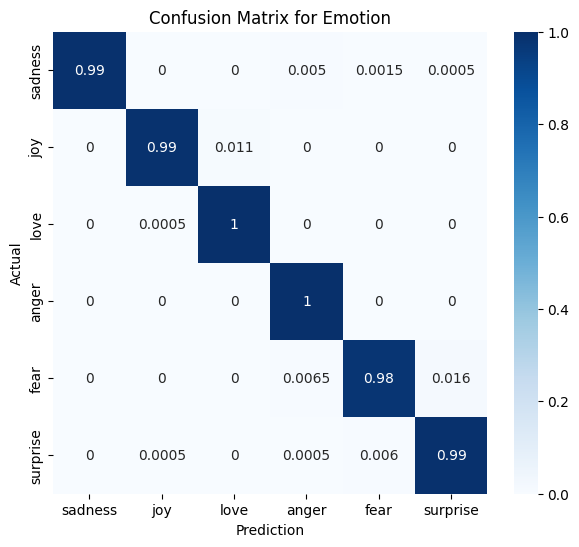

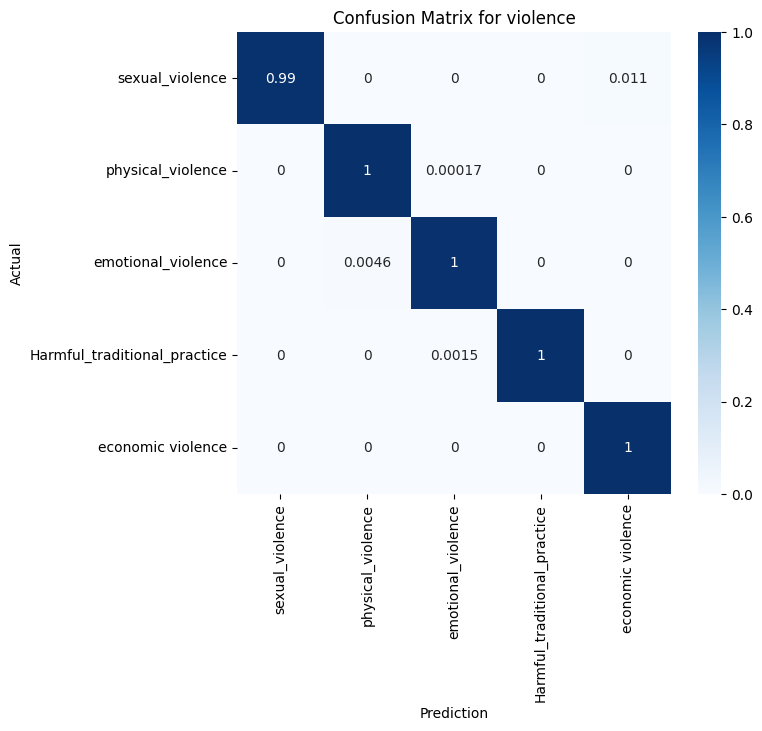

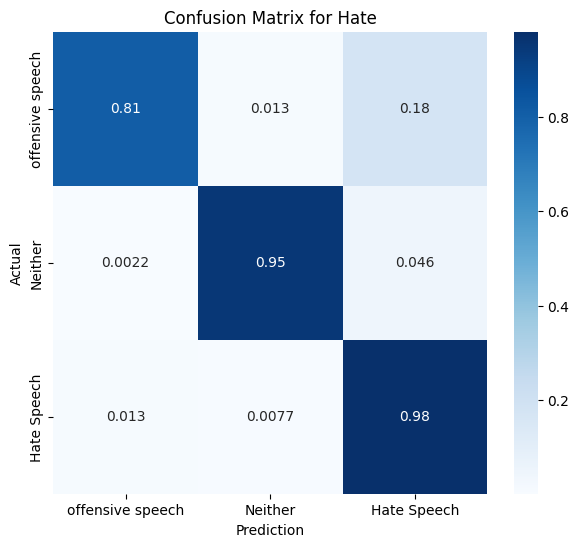

In [ ]:
plot_cm(emotion_labels, emotion_pred, 'Confusion Matrix for Emotion', emotion_labels_text)
plot_cm(violence_labels, violence_pred, 'Confusion Matrix for violence', violence_labels_text)
plot_cm(hate_labels, hate_pred, 'Confusion Matrix for Hate', hate_labels_text)

**8. Manual Testing**

In [ ]:
def classify_text(input_text):
  #preprocess the input text
  input_text_cleaned = remove_stopwords(input_text)
  input_sequence = tokenizer.texts_to_sequences([input_text_cleaned])
  input_padded = pad_sequences(input_sequence, maxlen = max_length, padding = 'post')

  #prediction
  predictions = model.predict({'emotion_input' : input_padded,
                            'violence_input' : input_padded,
                            'hate_input' : input_padded})
  emotion_pred = np.argmax(predictions[0], axis = 1)[0]
  violence_pred = np.argmax(predictions[1], axis = 1)[0]
  hate_pred = np.argmax(predictions[2], axis = 1)[0]

  #determine major label
  major_labels = ['Emotion', 'Violence', 'Hate']
  major_label_index = np.argmax([np.max(predictions[0]), np.max(predictions[1]), np.max(predictions[2])])
  major_label = major_labels[major_label_index]

  #determing sub - labels
  emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
  violence_labels_text = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic violence']
  hate_labels_text = ['offensive speech', 'Neither', 'Hate Speech']

  if major_label == 'Emotion':
    sub_label = emotion_labels_text[emotion_pred]
  elif major_label == 'Violence':
    sub_label = violence_labels_text[violence_pred]
  else:
    sub_label = hate_labels_text[hate_pred]

  return major_label, sub_label

In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
#define a text widget and a placeholder
input_text_widget = widgets.Text(
    description = 'Input text : ',
    placeholder = 'Enter you text'
)

In [ ]:
#define classify button
button = widgets.Button(description = 'classify')

In [ ]:
#define an output area to display result
output = widgets.Output()

In [ ]:
#function to handle event
def on_button_click(b):
  with output:
    output.clear_output()   #clear the previous output
    input_text = input_text_widget.value
    major_label, sub_label = classify_text(input_text)
    print(f'Major Label : {major_label}')
    print(f'Sub Label : {sub_label}')

#attach the button at bottom
button.on_click(on_button_click)

In [ ]:
display(input_text_widget, button, output)

Text(value='', description='Input text : ', placeholder='Enter you text')

Button(description='classify', style=ButtonStyle())

Output()